# Forecast_Submissions
## Name: Xiang Zhong
### Date: 11/21/2021
### Assignment Number: 13
-----
### Purpose of this notebook
Get next two weeks' forecast value of the streamflow for Camp Verde

-----
### Forecast logic
To do the forecast this week, I used a weight function to generate the final forecast value.

Two parameters were used in the function. The first parameter is a historical climatology streamflow value for the corresponding week. The second parameters were generated based on the median value of df (change in flow) when the dp (change in precipitaiton) is zero or not. Took probability of precipitation from weather forecast website, then use df in dp != 0 times the probability add dp ==0 times (1 - probability) get the trend. Add the trend to get a forecast value as the second parameter. Subtitude the two parameters and manual weight number to get the two final forecast values.

-----
### Evolvement of forecast
My forecast logic has evolved from pure streamflow to a combination of streamflow and relative humidity or precipitation. Tried to establish relationship between streamflow and lag-1/2 week flow, or with relative humidity or precipitation. The relationship established before were not statistically significant, therefore in this forecast logic, I simply used a median value as the trend. Considering precipitation equals zero or not are different situations, got two trends respectively. 

-----
### Added session this week
This week I chose a heatmap as my first plot. This heatmap is historical streamflow value for next week and next next week at each year from 1989 to 2020. The link from the gallery is: https://plotly.com/python/v3/ipython-notebooks/scoreboard-heatmaps/. But at last because importing plotly.plotly fails all the time, I googled "Python heatmap" and used sns.heatmap to get a heatmap instead.

-----
### Evaluation Rubric
1. Is the script easy to read and understand?
- Are variables and functions named descriptively when useful?
- Are the comments helpful?
- Can you run the script on your own easily?
- Are the doc-strings useful?

2. Does the code follow PEP8 style consistently?
- If not are there specific instances where the script diverges from this style?

3. Is the code written succinctly and efficiently?
- Are there superfluous code sections?
- Is the use of functions appropriate?
- Is the code written elegantly without decreasing readability?

## Grade: 
- **Readability: 3/3** - Great job with the jupyter notebook. I really like how you used markdown cells to provide captions and explain your figures. 
- **Style: 3/3** - One comment I didnt subtract points for this but I dont think you need to break your code into so many cells. You can put all of the cells together that are needed to generate one output so the user doesn't have to click through as many steps unless there are intermediate outputs you want to pause and show them along the way. 
- **Code: 3/3** Awesome! I like how you have your function in a separate file. I ran it with no trouble all of your paths worked and your graphs generated well. I like the heat map that you added!

In [1]:
# Import the modules we will use
import Forecast_function as FF
import numpy as np
import dataretrieval.nwis as nwis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

In [2]:
# Define the parameters will be used later
Forecast_parm = np.zeros((2,2))

In [3]:
## Get 1st parameter
# Grab streamflow data
station_id = '09506000'
start_formatted = '1989-01-01'
stop_formatted = '2021-11-20'
data = nwis.get_record(sites=station_id, service='dv',
                       start=start_formatted, end=stop_formatted,
                       parameterCd='00060')

In [4]:
# Get the mean value of week_1 for each year
m = 11
week1_data = data[(data.index.month == m) &
                 (data.index.day <= 27) &
                 (data.index.day >= 21)]

week1_data['year'] = week1_data.index.year

week1_data = week1_data.groupby(['year']).mean()

/var/folders/3w/jbn7kjwj0vl22h500w7bkfqh0000gn/T/ipykernel_29115/3286607637.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week1_data['year'] = week1_data.index.year


In [5]:
# Get the mean value of week_2 for each year
week2_data = data[((data.index.month == m) &
                 (data.index.day >= 28)) |
                 ((data.index.month == m + 1) &
                 (data.index.day <= 4))]

week2_data['year'] = week2_data.index.year

week2_data = week2_data.groupby(['year']).mean()

/var/folders/3w/jbn7kjwj0vl22h500w7bkfqh0000gn/T/ipykernel_29115/1996806082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week2_data['year'] = week2_data.index.year


In [6]:
# Get the 1st parameter
Forecast_parm[0, 0] = np.median(week1_data['00060_Mean'])
Forecast_parm[1, 0] = np.median(week2_data['00060_Mean'])

In [7]:
# 1st Plot - Prepare the data
Heatmap_1 = np.array([week1_data['00060_Mean'][0:8], week2_data['00060_Mean'][0:8]])
Heatmap_2 = np.array([week1_data['00060_Mean'][8:16], week2_data['00060_Mean'][8:16]])
Heatmap_3 = np.array([week1_data['00060_Mean'][16:24], week2_data['00060_Mean'][16:24]])
Heatmap_4 = np.array([week1_data['00060_Mean'][24:32], week2_data['00060_Mean'][24:32]])

<AxesSubplot:>

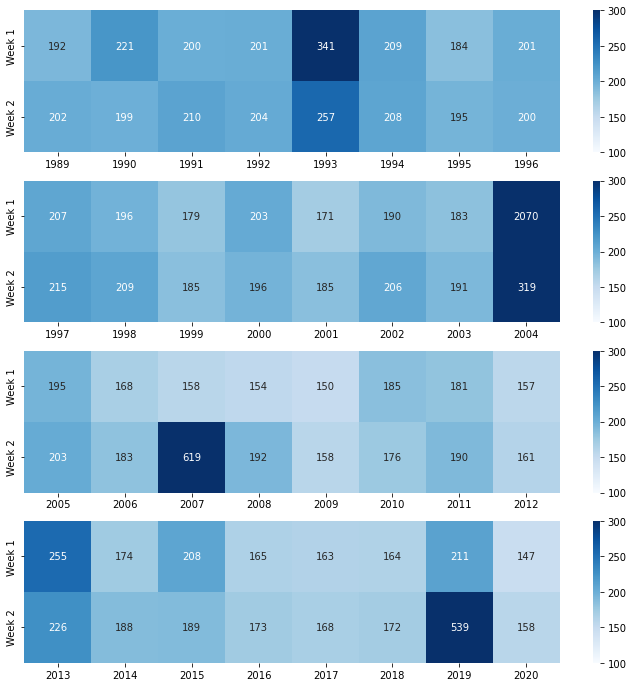

In [8]:
# 1st Plot - Get the figure
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))
sns.heatmap(Heatmap_1, vmin=100, vmax=300, cmap='Blues',
                    xticklabels=week1_data.index[0:8],
                    yticklabels=['Week 1', 'Week 2'],
                    annot=True, fmt='.0f', ax=ax[0])
sns.heatmap(Heatmap_2, vmin=100, vmax=300, cmap='Blues',
                    xticklabels=week1_data.index[8:16],
                    yticklabels=['Week 1', 'Week 2'],
                    annot=True, fmt='.0f', ax=ax[1])
sns.heatmap(Heatmap_3, vmin=100, vmax=300, cmap='Blues',
                    xticklabels=week1_data.index[16:24],
                    yticklabels=['Week 1', 'Week 2'],
                    annot=True, fmt='.0f', ax=ax[2])
sns.heatmap(Heatmap_4, vmin=100, vmax=300, cmap='Blues',
                    xticklabels=week1_data.index[24:32],
                    yticklabels=['Week 1', 'Week 2'],
                    annot=True, fmt='.0f', ax=ax[3])

This figure is the historical values for next week and next next week at each year from 1989 to 2020. From this figure we can find that most values are between 150 to 200. There are some extreme values, making median value a better representative than mean value.

In [9]:
## Get 2nd parameters
# Load precipitation data
url = "https://daymet.ornl.gov/single-pixel/api/data?lat=34.9455&lon=-113.2549" \
       "&vars=prcp&years=&format=csv"
precip = pd.read_table(url, delimiter=',', skiprows=6)
precip = precip[precip['year'] >= 1989]
precip['prcp_s1'] = precip.iloc[:, 2].shift(1)
precip['d_p'] = precip.iloc[:, 2] - precip.iloc[:, 3]

In [11]:
# Get a trend: df
data['flow_s1'] = data.iloc[:, 0].shift(1)
data['d_f'] = data.iloc[:, 0] - data.iloc[:, 3]
precip_dp = precip['d_p'][1: 11681]
data_sel = data[(data.index.year <= 2020) &
     ((data.index.month !=2) |
     ((data.index.month == 2) &
      (data.index.day != 29)))
     ]
flow_df = data_sel['d_f'][1: 11681]

model_data = pd.DataFrame(list(zip(precip_dp, flow_df)),
                     columns=['precip','flow'])
trend_nonzero = np.median(model_data[model_data['precip'] != 0]['flow'])
trend_zero = np.median(model_data[model_data['precip'] == 0]['flow'])

In [12]:
# Get trend for next two weeks
pop_week1 = np.array([0.2, 0.3, 0.4, 0, 0, 0.2, 0.3])  # pop is the probability of precipitation
pop_week2 = np.array([0.2, 0.2, 0.1, 0.2, 0.2, 0.2, 0.2])

trend_week1 = trend_nonzero * np.mean(pop_week1) + trend_zero * (1-np.mean(pop_week1))
trend_week2 = trend_nonzero * np.mean(pop_week2) + trend_zero * (1-np.mean(pop_week2))

In [13]:
# Forecast next two weeks' flow according to the trend
fore_week1 = np.zeros(7)
for i in range(1, 8):
    fore_week1[i-1] = data.tail(1)['00060_Mean'] + trend_week1 * i
fore_week2 = np.zeros(7)
for i in range(1, 8):
    fore_week2[i-1] = fore_week1[6] + trend_week2 * i

In [14]:
# 2nd parameters
Forecast_parm[0, 1] = np.mean(fore_week1)
Forecast_parm[1, 1] = np.mean(fore_week2)

[Text(0.5, 0, 'Days ahead (d)'),
 Text(0, 0.5, 'Forecast flow (cfs)'),
 Text(0.5, 1.0, "Next two weeks' forecast flow")]

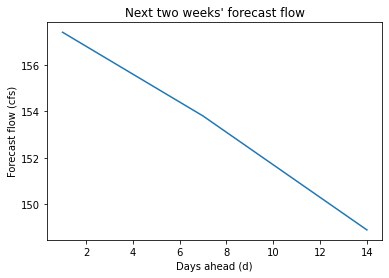

In [15]:
# Plot 2 - Timeseries of next two weeks' forecast flow
fig, ax = plt.subplots()

ax.plot(range(1, 15),
        np.array([fore_week1, fore_week2]).reshape(14, ))
ax.set(xlabel='Days ahead (d)', ylabel='Forecast flow (cfs)',
       title="Next two weeks' forecast flow")

# fig.set_size_inches(5, 3.5)
# fig.savefig("HW10_Plot_3.png")


This is a time series of the forecast value for next two weeks based on the logic of getting the trend of flow when there is precipitation or not. Because the probability to rain is not very high for the next two weeks, the forecast flow values show a decreasing trend.

In [16]:
# Get the final forecast value for next two weeks
fore_week1_final = FF.cal_forecast(Forecast_parm[0, :], np.array([0.1, 0.9]))
print('The forecast value for week 1 is: ', fore_week1_final)
fore_week2_final = FF.cal_forecast(Forecast_parm[1, :], np.array([0.2, 0.8]))
print('The forecast value for week 2 is: ', fore_week2_final)

The forecast value for week 1 is:  159
The forecast value for week 2 is:  160


In [17]:
## Map with forecasted value
# Add a point locating at Camp Verde
point = np.array([-111.7891667, 34.44833333])
point_geom = Point(point)
point_df = gpd.GeoDataFrame({'Name': ['Camp_Verde'], 'geometry': [point_geom]}, crs='WGS84')

Text(34.57000000000001, 0.5, 'Latitude')

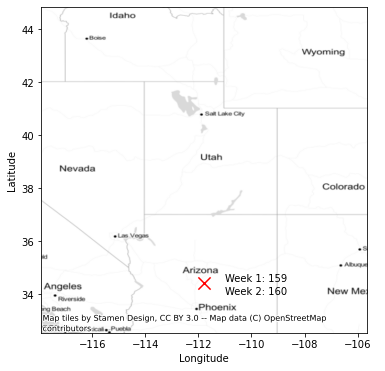

In [18]:
# Plot the map
fig, ax = plt.subplots(figsize=(6, 6))

# Layer 1
point_df.plot(ax=ax, color='red', marker='x',
                    markersize=150)
plt.axis('square')
# Layer 2
ax.text(-111,34.5, 'Week 1: 159')
ax.text(-111,34, 'Week 2: 160')
# Layer 3
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs='WGS84')
# Add axes labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

This map is simply a basemap plus a mark of Camp Verde, and added the two forecast streamflow values.
